# Installation and Imports

In [1]:
pip install -U sentence-transformers


     |████████████████████████████████| 79 kB 2.1 MB/s 
     |████████████████████████████████| 3.8 MB 25.4 MB/s 
     |████████████████████████████████| 1.2 MB 44.2 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 37.2 MB/s 
     |████████████████████████████████| 895 kB 51.7 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b84ca69cd41e9a04c36ddc312af54caf6559f55743a729ed127c81da9f49d758
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [27]:
from torch.utils.data import DataLoader
import math
import logging
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk, re, string, collections
from nltk.util import ngrams
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import gensim
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import sklearn
from sklearn.model_selection import train_test_split
import os
import gzip
import csv
import random
import keras
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [28]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset Load

Loading the dataset in the system and concatinating them into one dataframe. With Fake being classified as with class 0 and real as class 1.

Loading the CSV

In [31]:
fake = pd.read_csv('./Fake_New.csv')
real = pd.read_csv('./Real_New.csv')

In [32]:
fake['Target']=0
real['Target']=1

In [33]:
frames = [fake, real]

df = pd.concat(frames)

In [34]:
df = df.sample(frac=1).reset_index(drop=True)

In [36]:
df_=df.copy()
df_=df_.reset_index(drop=True)


In [40]:
df_['news'] = df_['title']+' '+df_['text']

In [ ]:
df_['news'] = df_['title']+' '+df_['text']
df_['news'] = df_.apply(lambda x: str(x['news']).lower(),axis=1)
df_["news"] = df_['news'].str.replace('[^\w\s]','')
all_news=pd.DataFrame(pd.Series(' '.join(df_['news']).split()).value_counts())
allnews1=all_news.head(30)

In [180]:
import matplotlib.pyplot as plt
df.isna().sum()
from wordcloud import WordCloud

In [185]:
df_.isna().sum()

text = " ".join(news for news in df_.news)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

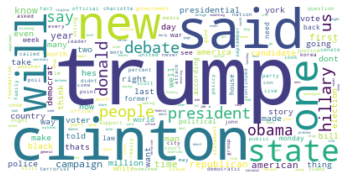

In [188]:
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")

plt.show()

In [192]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

label_encoder = LabelEncoder()
df_.iloc[:,0] = label_encoder.fit_transform(df_.iloc[:,0]).astype('float64')

In [193]:
corr = df_.corr()

Split the data into testing and training datasets

In [201]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0,test_size=0.2)

In [65]:
X_train

75     trump just made a campaign promise so ridiculo...
64     worst president ever as my 25th wedding annive...
55                                                   nan
81     new clinton foundation scandal just broke  thi...
306    trumpclinton debates will stream on twitter on...
                             ...                        
323    mcconnell pelosi ryan seek deal on government ...
192    clinton demands charlotte police video release...
117    obama refugee crisis is test of our humanity u...
47     texas california separatists attend kremlinfun...
172    the 8 biggest unforced errors in debate histor...
Name: news, Length: 321, dtype: object

In [ ]:
np.array(X_train)

# Sentence Embedding

Loading the model to get sentence embedding for all the data. The model is a pretrained model that uses the BERT deep learning model called SBERT. /cite the paper here

In [168]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings_train = model.encode(np.array(X_train))

embeddings_test = model.encode(np.array(X_test))

In [169]:
embeddings_train = np.reshape(embeddings_train, embeddings_train.shape + (1,))
embeddings_test = np.reshape(embeddings_test, embeddings_test.shape + (1,))

# Model for predection
The model will accept the embeddings as an input and give us the predection if the news is fake or real based on it

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

feature_vector_length = 384
num_classes = 2

input_shape = embeddings_train.shape

Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

model = Sequential()
model.add(layers.Convolution1D(16,4,activation='relu'))
model.add(layers.AveragePooling1D())
model.add(layers.Convolution1D(32,4,activation='relu'))
model.add(layers.AveragePooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='sigmoid'))

# Training the model
Train the model on trainig data and embeddings

In [171]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
model.fit(embeddings_train, Y_train, epochs=500, batch_size=250, verbose=1, validation_split=0.2)

Epoch 1/500
2/2 [==============================] - 2s 925ms/step - loss: 0.6934 - accuracy: 0.4908 - precision_28: 0.4807 - recall_28: 0.4103 - auc_28: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4638 - val_precision_28: 0.5000 - val_recall_28: 0.3333 - val_auc_28: 0.4983
Epoch 2/500
2/2 [==============================] - 0s 51ms/step - loss: 0.6930 - accuracy: 0.5092 - precision_28: 0.5253 - recall_28: 0.3810 - auc_28: 0.4982 - val_loss: 0.6937 - val_accuracy: 0.4638 - val_precision_28: 0.4706 - val_recall_28: 0.4638 - val_auc_28: 0.4761
Epoch 3/500
2/2 [==============================] - 0s 39ms/step - loss: 0.6925 - accuracy: 0.5092 - precision_28: 0.5130 - recall_28: 0.5055 - auc_28: 0.5396 - val_loss: 0.6936 - val_accuracy: 0.4638 - val_precision_28: 0.4762 - val_recall_28: 0.4348 - val_auc_28: 0.4887
Epoch 4/500
2/2 [==============================] - 0s 39ms/step - loss: 0.6923 - accuracy: 0.5092 - precision_28: 0.5178 - recall_28: 0.4799 - auc_28: 0.5423 - val_loss: 0.6935 - val_

# Testing the model
Testing the model with the test data

In [203]:
test_results = model.evaluate(embeddings_test, Y_test, verbose=1)

11/11 [==============================] - 0s 12ms/step - loss: 0.6384 - accuracy: 0.7193 - precision_28: 0.7184 - recall_28: 0.7310 - auc_28: 0.7958


## Logistic Regression

In [176]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0)
pipe1 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])

model_lr = pipe1.fit(X_train, y_train)

lr_pred = model_lr.predict(X_test)

print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test, lr_pred)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test, lr_pred))

Accuracy of Logistic Regression Classifier: 37.38%

Confusion Matrix of Logistic Regression Classifier:

[[18 36]
 [31 22]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.37      0.33      0.35        54
           1       0.38      0.42      0.40        53

    accuracy                           0.37       107
   macro avg       0.37      0.37      0.37       107
weighted avg       0.37      0.37      0.37       107



## SVM

In [177]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0)
pipe2 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LinearSVC())])

model_svc = pipe2.fit(X_train, y_train)
svc_pred = model_svc.predict(X_test)

print("Accuracy of SVM Classifier: {}%".format(round(accuracy_score(y_test, svc_pred)*100,2)))
print("\nConfusion Matrix of SVM Classifier:\n")
print(confusion_matrix(y_test, svc_pred))
print("\nClassification Report of SVM Classifier:\n")
print(classification_report(y_test, svc_pred))

Accuracy of SVM Classifier: 38.32%

Confusion Matrix of SVM Classifier:

[[18 36]
 [30 23]]

Classification Report of SVM Classifier:

              precision    recall  f1-score   support

           0       0.38      0.33      0.35        54
           1       0.39      0.43      0.41        53

    accuracy                           0.38       107
   macro avg       0.38      0.38      0.38       107
weighted avg       0.38      0.38      0.38       107



## Naive Bayes

In [178]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0)
pipe3 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

model_nb = pipe3.fit(X_train, y_train)
nb_pred = model_nb.predict(X_test)

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test, nb_pred)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test, nb_pred))
print("\nClassification Report of Naive Bayes Classifier:\n")
print(classification_report(y_test, nb_pred))

Accuracy of Naive Bayes Classifier: 39.25%

Confusion Matrix of Naive Bayes Classifier:

[[23 31]
 [34 19]]

Classification Report of Naive Bayes Classifier:

              precision    recall  f1-score   support

           0       0.40      0.43      0.41        54
           1       0.38      0.36      0.37        53

    accuracy                           0.39       107
   macro avg       0.39      0.39      0.39       107
weighted avg       0.39      0.39      0.39       107

